# Medicare.Gov Data Exploration in Oregon
#### Objectives:
1. Connect to Socrata Open Data API (SODA) with the following data points:
    - Post-Acute Facilties: 
        - https://data.medicare.gov/Nursing-Home-Compare/Provider-Info/4pq5-n9py
    - Penalties or fines: 
        - https://data.medicare.gov/Nursing-Home-Compare/Penalties/g6vv-u9sr
    - Long Term Care Minimum Data's quality Measures:
        - https://data.medicare.gov/Nursing-Home-Compare/MDS-Quality-Measures/djen-97ju
    - Center for Medicare and Medicaid Services Star Rating: 
        - https://data.medicare.gov/Nursing-Home-Compare/Star-Ratings/ax9d-vq6k
2. Run initial exploratory data analysis and ask the following questions:
    1. What are some frequency counts of interest?
    2. What are some trends that show high, low, increases, decreases, or outliers?
    3. What do histograms display?
    4. What are some quantities to compare?
    5. What scatter plots are interesting?
    6. What time of time series data trends are interesting?
3. What are some initial hypotheses or insights? What should I investigate next?
4. Data presentation
    - What are some ways to narrate this data?
    - What additional data do I need to make this story more complete?


## Setting up
- Load libraries
- set paths
- read data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt

%matplotlib inline

limits = "&$where=provider_state='OR'&$limit=20000"

# Read Provider
info = 'https://data.medicare.gov/resource/b27b-2uc7.json?$select='
info_cols = pd.Series([
    'federal_provider_number','provider_name','provider_state','provider_city','ownership_type',
    'number_of_certified_beds','number_of_residents_in_certified_beds','overall_rating','total_weighted_health_survey_score',
    'number_of_substantiated_complaints', 'number_of_fines', 'total_amount_of_fines_in_dollars',
    'number_of_payment_denials', 'total_number_of_penalties']).str.cat(sep = ',')
info = pd.read_json(info+info_cols+limits).set_index('federal_provider_number').sort_index()

# Read Penalty
fines = 'https://data.medicare.gov/resource/im9k-ugyp.json?$select='
fines_cols = pd.Series(['federal_provider_number','penalty_date','penalty_type','fine_amount']).str.cat(sep = ',')
# fines = pd.read_json(fines+fines_cols).set_index('federal_provider_number').sort_index()

# Read MDS
mds = 'https://data.medicare.gov/resource/adup-8cbx.json?$select='
mds_cols = pd.Series([
    'federal_provider_number',
    #'measure_code',
    #'measure_description','resident_type',
    'three_quarter_average']).str.cat(sep = ',')
mds = pd.read_json(mds + mds_cols+limits).set_index('federal_provider_number').sort_index()

# Read Star
star = 'https://data.medicare.gov/resource/ax9d-vq6k.json?$select='
star_cols = pd.Series(['federal_provider_number','health_inspection_rating','qm_rating','staffing_rating','rn_staffing_rating']).str.cat(sep = ',')
star = pd.read_json(star+star_cols+limits).set_index('federal_provider_number').sort_index()


C:\Users\Cglan\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
print(
info.shape,
mds.shape,
star.shape)

(137, 13) (2877, 1) (137, 4)


### A. Initial Transformations




In [3]:
# Compute rate of bed occupancy
info.occupancy_rate = info.number_of_residents_in_certified_beds/info.number_of_certified_beds

# join 3 star rating
info = info.merge(mds[['three_quarter_average']], left_index= True, right_index=True)

## 2. Run initial exploratory data analysis and ask the following questions:
###  Create Cross Tabs
#### Question: What are some frequency counts of interest?
Interested in the distribution of test scores by city, it seems that some cities have lower variation in test scores than others. Variation overall seems to be low.


In [4]:
owner_rating = pd.crosstab(
    info.overall_rating,
    info.provider_city) # "index" for rows, 'columns' for columns
owner_rating

provider_city,ALBANY,ASHLAND,ASTORIA,BEAVERTON,BEND,BROOKINGS,CANBY,COOS BAY,CORVALLIS,COTTAGE GROVE,...,SWEET HOME,THE DALLES,TIGARD,TUALATIN,VALE,WEST LINN,WHEELER,WILSONVILLE,WOOD VILLAGE,WOODBURN
overall_rating,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,21,0,0,0,0,0,0,0
2,21,0,0,21,0,0,0,0,0,0,...,0,0,0,0,0,0,21,0,0,0
3,21,21,21,0,0,0,0,21,0,0,...,0,0,0,0,0,0,0,0,0,21
4,0,0,0,0,42,21,0,21,21,21,...,21,63,21,21,0,21,0,0,0,0
5,21,0,0,21,21,0,21,0,0,0,...,0,0,0,0,21,0,0,21,21,0


### C. Scatter Matrices
#### Question: What are some trends that show high, low, increases, decreases, or outliers?
    - How do administrative variables (bed capacity) affect ratings? 
        - There is seemingly little correlation that is unexpected.
#### Question: What scatter plots are interesting?
    - Looking at survey scores vs overall rating show a correlation
    - as expected, the correlation between number of beds available and number of residents in bed rises.
    - there is a downward trajectory with weighted survey score and overall rating 
    
#### Setting up the data

In [5]:
to_scatter_matrix = info.select_dtypes(exclude=['object'])
to_scatter_matrix = to_scatter_matrix[[0,3,5,6,8]]

#### Info Scatter Matrix

C:\Users\Cglan\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


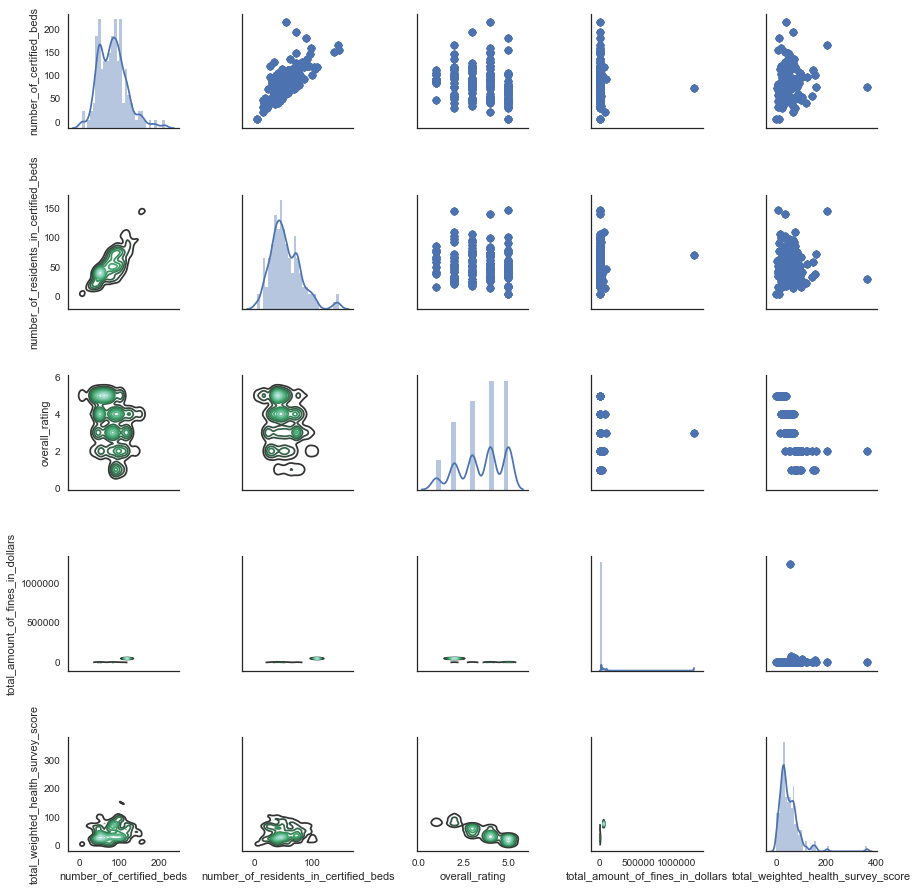

In [6]:
# http://seaborn.pydata.org/examples/pair_grid_with_kde.html
plt.pylab.rcParams['figure.figsize'] = (16, 16)

sns.set(style="white")

df = to_scatter_matrix

g = sns.PairGrid(df, diag_sharey=False)
g.map_lower(sns.kdeplot,)
g.map_upper(plt.pyplot.scatter)
g.map_diag(sns.distplot)


### D. Factor Plot, Looking at STAR test
#### Question: What do histograms display?
     - Interestingly, there are many staff ratings where staff gains 3 or above. Ratings of 2 and 3 are rare. Yet, Registered Nurse staff rating seems to have more variation. The only rating that seems to even have the slightest normal distribution would be staff rating (if the long left tail of scores 1 and 2 were removed). This could suggest that the test should be changed. 
     
     - The health inspection rating seems more uniformly distributed 

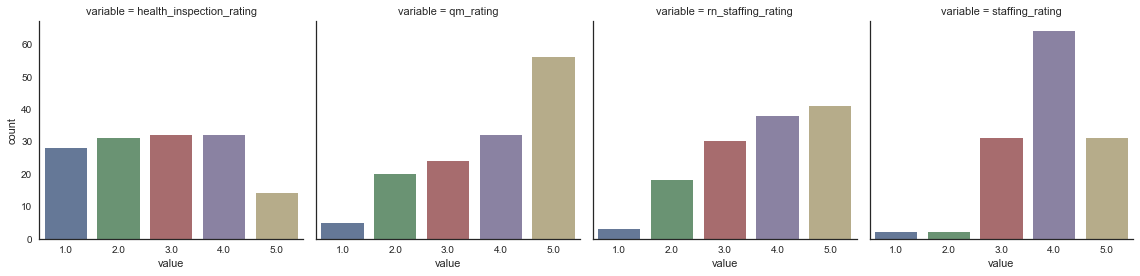

In [7]:
# https://stackoverflow.com/questions/38152686/iterating-over-columns-with-for-loops-in-pandas-dataframe
# http://seaborn.pydata.org/generated/seaborn.factorplot.html

star_melt = pd.melt(
    frame=star,
    value_vars=['health_inspection_rating', 'qm_rating', 'rn_staffing_rating','staffing_rating'])
star_melt = star_melt.groupby(['variable','value']).size()
star_melt = star_melt.reset_index()

star_melt.rename(
    columns={0: 'count'},
    inplace=True)

_ = sns.factorplot(x="value", y="count", col="variable",
            data=star_melt, saturation=.5,
            kind="bar", ci=None, aspect=1)


### Data Transformation for Facility Capacity

In [8]:
# http://pbpython.com/pandas-pivot-table-explained.html
# http://matplotlib.org/1.4.3/examples/color/colormaps_reference.html
# https://stackoverflow.com/questions/30353363/seaborn-regplot-with-colorbar
# https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger

table_bed_capacity = info.pivot_table(
    index = ['provider_state'],
    columns = ['provider_city'],
    values = ['number_of_residents_in_certified_beds', 'number_of_certified_beds','three_quarter_average'],    
     aggfunc={
         'number_of_residents_in_certified_beds':np.sum,
          'number_of_certified_beds':np.sum,
         'three_quarter_average':np.mean       
     },
    fill_value=0,
    margins = True)

table_bed_capacity = table_bed_capacity.stack('provider_city')
table_bed_capacity = table_bed_capacity.query('number_of_residents_in_certified_beds != 0')
table_bed_capacity['rate'] = table_bed_capacity.number_of_residents_in_certified_beds/table_bed_capacity.number_of_certified_beds
table_bed_capacity_wo_all = table_bed_capacity.query("provider_city != ['All'] & provider_state != ['All']")
table_bed_capacity_wo_all.sort_values('rate', ascending = 0)
mean_rate = sum(table_bed_capacity_wo_all.number_of_residents_in_certified_beds)/sum(table_bed_capacity_wo_all.number_of_certified_beds)
table_bed_capacity_wo_all['low_high'] = np.where(table_bed_capacity_wo_all.rate >= mean_rate, 'Above Mean Rate','Below Mean Rate')
table_bed_capacity_wo_all = table_bed_capacity_wo_all.reset_index()
table_bed_capacity_wo_all.provider_city = table_bed_capacity_wo_all.provider_city.str.title()
table_bed_capacity_wo_all.sort_values('number_of_certified_beds', ascending = 0).head()


C:\Users\Cglan\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,provider_state,provider_city,number_of_certified_beds,number_of_residents_in_certified_beds,three_quarter_average,rate,low_high
44,OR,Portland,51450.0,36750.0,0.276849,0.714286,Above Mean Rate
12,OR,Eugene,16044.0,11550.0,0.293843,0.719895,Above Mean Rate
16,OR,Grants Pass,8610.0,5313.0,0.284838,0.617073,Below Mean Rate
17,OR,Gresham,8274.0,5649.0,0.292098,0.682741,Above Mean Rate
32,OR,Medford,7623.0,6027.0,0.295342,0.790634,Above Mean Rate


### Create Bokeh Scatter Function

In [9]:
# http://bokeh.pydata.org/en/latest/docs/user_guide/notebook.html
# http://bokeh.pydata.org/en/latest/docs/gallery/elements.html
# http://bokeh.pydata.org/en/0.11.1/docs/user_guide/tools.html

from bokeh import io, plotting, models, palettes, resources
from bokeh.models.sources import ColumnDataSource

def scatter_plotter(
    data_in = table_bed_capacity_wo_all,
    x_in = 'rate',
    y_in = 'three_quarter_average',
    label_in = 'provider_city',
    color_in = 'low_high'):
    
    data_source_in = ColumnDataSource(data_in)
    # transform args
    y_in_pretty = y_in.replace('_',' ').title()
    x_in_pretty = x_in.replace('_',' ').title()
    label_in_pretty = label_in.replace('_',' ').title()
    list_of_factors = data_source_in.to_df()[[color_in]].drop_duplicates()[color_in].tolist()

    
    io.output_notebook()

    #color makker 
    color_mapper = models.CategoricalColorMapper(
        factors = list_of_factors,
        palette = [palettes.RdBu3[2], palettes.RdBu3[0]])
    #tool tip creator
    hover = models.tools.HoverTool(
        tooltips = [
            (y_in_pretty, '@' + y_in),
            (x_in_pretty, '@' + x_in),
            (label_in_pretty,' @' + label_in)])
    # tools selection
    tool_input = [hover,'wheel_zoom,box_zoom,reset,pan']
    # Instantiate Scatter / Bokeh Figure
    p = plotting.figure(
        tools = tool_input, 
        title = x_in_pretty + ' vs ' + y_in_pretty)
    p.circle(
        x = x_in,
        y = y_in, 
        source = data_source_in,
        size = 15,
        color = {
            'field': color_in ,
            'transform': color_mapper},
        legend = color_in)
    # Add Labels
    labels = models.LabelSet(
        x= x_in,
        y= y_in,
        text=label_in,
        y_offset=8,
        text_font_size="8pt", text_color="#555555",
        source=data_source_in,
        text_align='center')
    p.add_layout(labels)
    # Axes
    p.xaxis.axis_label= x_in_pretty
    p.yaxis.axis_label= y_in_pretty
    # show!
    io.show(p)


### E. Scatter Plots for Capacity
#### Question: What are some quantities to compare? 

In this section I copare occupancy rate ( a variable created using number of available beds and number of residents in bed) against three quarter average to see how capacity and ratings seem to move together. I color code higher than average and lower than average occupancy rates. 
- Seemingly there is no trend. 


In [10]:
scatter_plotter(
    x_in = 'number_of_certified_beds',
    y_in = 'number_of_residents_in_certified_beds')
scatter_plotter()

Loading BokehJS ...

Loading BokehJS ...

#### Question: What are some initial hypotheses or insights? What should I investigate next?
    - A few insignts to explore:
        - One area to investigate is how the Oregon area compares to other regions.
        - Of the quality ratings, which are most correlated to patient satisfaction?
        - How does quality ratings affect the rate of medicare payment penalization or non-payment? and Does a better staff rating result in fewer penalties?
    - A couple of hypotheses to test:
        - Do administrative variables such as "type of ownership" affect overall ratings?
        - Does staffing quality affect patient stay quality?
#### Question: What are some ways to narrate this data?
        - Utilizing a static deck which allows one to walk an audience through: 
            - Financial outcomes
            - Patient Outcomes
            - and Quality Ratings 
            ... would do well in communicating the landscape of a specific geographic area -- when it comes to visualizing data regarding the entire nation -- it becomes more difficult as trends begin to be buried due to many state by state differences. Focusing on a single market would be the best solution in directing a story line. Given that an audience member has understood initial localized markets -- the next step would be to show a larger national picture where they can ask questions about broader implications of local markets. I believe this is important because local health care markets, being so different, provide an opportunity to understand the driving differences in the post-acute sector where region-specific variables such as cost of living, age distribution,  demographic distribution, family / mental health dynamics, and of course transportation plays a large role. 
        - Given the above contextualization, a broader understanding of the landscape can be achieved in a more interactive manner. A broarder narrative would involve an interactive selector with the following features:
            - Region selector: Country Region > State > City or Zip Code
            - Domain Selector: where one can select "quality ratings" "penalties / non payment" or customer" satisfaction"
            - Then have dynamic scatter plots tell which facilities are above or below the national average.
            - Each level would provider benchmarks given the higher-level average. For example, a state level view would display national level statistics as benchmarks.
#### Question: What additional data do I need to make this story more complete?
        - I believe more data around patient outcomes would complete the story. Imagine being able to look at diagnosis groups of patients. How do patients are in for cardiac episodes compare to patients who come in for hip surgeries? 
        - Do the groups above differ when it comes to readmission rates into hospitals when we look at the quality rating of staff?
        